In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testdata/Test7.jpeg
/kaggle/input/testdata/dog.jpeg
/kaggle/input/testdata/Food-3.jpg
/kaggle/input/testdata/Test3.jpeg
/kaggle/input/testdata/Food-1.jpeg
/kaggle/input/testdata/Food-2.jpeg
/kaggle/input/testdata/Test1.jpeg
/kaggle/input/testdata/Food-5.jpeg
/kaggle/input/testdata/Test6.jpeg
/kaggle/input/testdata/Food-4.jpeg
/kaggle/input/testdata/Test2.jpeg
/kaggle/input/testdata/Test5.jpeg
/kaggle/input/testdata/Test4.jpeg


In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook

In [4]:
pip install fastbook --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import fastbook

In [6]:
fastbook.setup_book()
from fastbook import *

In [7]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [8]:
from fastdownload import download_url
from fastai.vision.all import *

In [9]:
searches = 'photo of nike sneakers','photo of adidas sneakers'
downloaded_path = Path("downloaded_shoes")
resized_path = Path("resized_shoes")

for o in searches:
    downloaded_dest = (downloaded_path/o)
    downloaded_dest.mkdir(exist_ok=True, parents=True)
    download_images(downloaded_dest, urls=search_images(f'{o} photo'))
    resize_images(downloaded_path/o, max_size=400, dest=resized_path/o)

In [10]:
failed = verify_images(get_image_files(resized_path))
failed.map(Path.unlink)
len(failed)

0

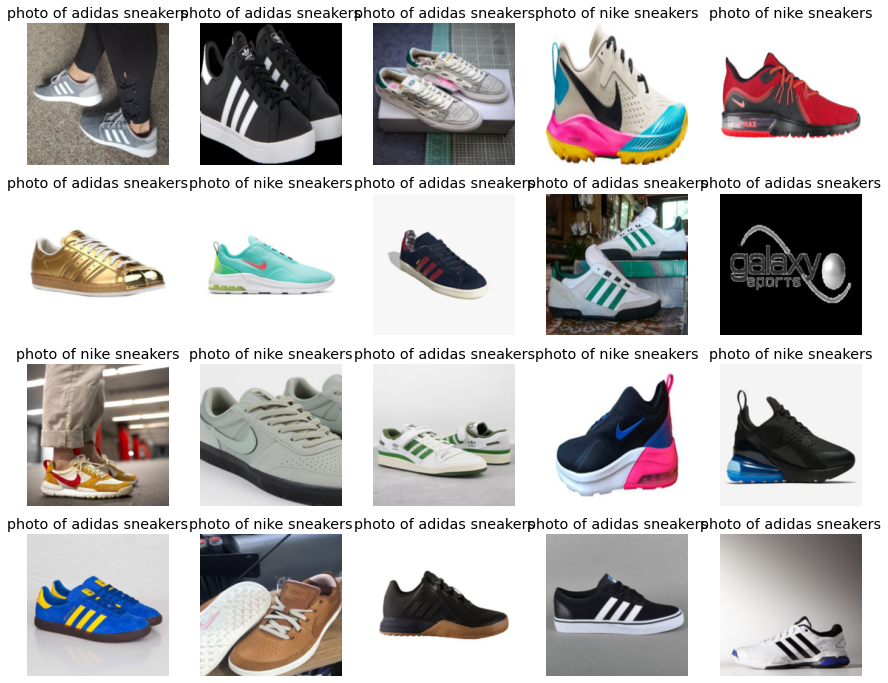

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(resized_path)

dls.show_batch(max_n=20)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(30)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.173436,0.661816,0.298507,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.777493,0.607224,0.298507,00:03
1,0.640350,0.611552,0.328358,00:03
2,0.523753,0.649275,0.313433,00:03
3,0.436766,0.675940,0.328358,00:03
4,0.363901,0.685066,0.298507,00:03
5,0.298513,0.684808,0.253731,00:03
6,0.251043,0.686138,0.253731,00:03
7,0.214795,0.742059,0.238806,00:03
8,0.183591,0.757517,0.208955,00:03
9,0.158894,0.759340,0.223881,00:03


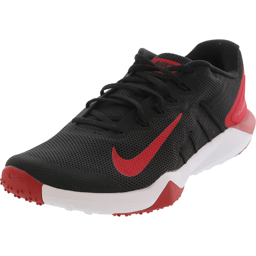

In [13]:
download_url(search_images('photo of a nike sneaker', max_images=1)[0], 'nike-sneaker.jpg', show_progress=False)
Image.open('nike-sneaker.jpg').to_thumb(256,256)

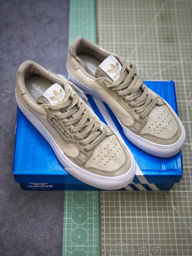

In [14]:
download_url(search_images('photo of a adidas sneaker', max_images=1)[0], 'adidas-sneaker.jpg', show_progress=False)
Image.open('adidas-sneaker.jpg').to_thumb(256,256)

In [17]:
is_nike,_,probs = learn.predict(PILImage.create('adidas-sneaker.jpg'))
print(f"This is a: {is_nike}.")
print(f"Probability it's a Nike Sneaker: {probs[0]:.4f}")

This is a: photo of adidas sneakers.
Probability it's a Nike Sneaker: 1.0000


In [16]:
is_adidas,_,probs = learn.predict(PILImage.create('adidas-sneaker.jpg'))
print(f"This is a: {is_adidas}.")
print(f"Probability it's a Adidas Sneaker: {probs[0]:.4f}")

This is a: photo of adidas sneakers.
Probability it's a Adidas Sneaker: 1.0000
